In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import IPython.display as ipd
import librosa

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
from torch import nn
from torch.nn import functional as F
import torch
from birds_utils import get_fourier_weights, DataGeneratorV2, Dataset, get_pytorch_model

In [6]:
import torchvision

In [7]:
sr = 44100
# train_files = np.load(f'train_files_{sr}.npy')
# train_labels = np.load(f'train_labels_{sr}.npy')
# val_files = np.load(f'val_files_{sr}.npy')
# val_labels = np.load(f'val_labels_{sr}.npy')

train_files = np.load(f'train_files.npy')
train_labels = np.load(f'train_labels.npy')
val_files = np.load(f'val_files.npy')
val_labels = np.load(f'val_labels.npy')

train_files = [f.replace('npy_22050', 'npy_44100') for f in train_files]
val_files = [f.replace('npy_22050', 'npy_44100') for f in val_files]

N = 2
min_std = 0.5
duration = 5

params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 1}
classes = np.unique(train_labels)

training_set = Dataset(list(train_files)*N, classes, chunk_seconds=duration, sr=sr, min_std=min_std)
training_generator = torch.utils.data.DataLoader(training_set, **params)

In [8]:
for X, y in training_generator:
    break

In [9]:
X = X.to(device)

In [10]:
X.type()

'torch.cuda.FloatTensor'

In [11]:
window_size = 1024

In [12]:
# nn.Sequential(*list(model_resnet.children())[:-1])

In [13]:
model = get_pytorch_model(window_size, resnet='resnet18', pretrained=True, n_classes=10, init_fourier=True, train_fourier=False).to(device)

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [14]:
# model = torch.load('model_1_sec_18.pth')

In [15]:
# Fourier not trainable
list(model.cos.parameters())[0].requires_grad

False

In [16]:
# plt.plot(model.cos.weight.data[0, 0, :])
# plt.plot(model.cos.weight.data[1, 0, :])

In [17]:
%time
model.eval()
spec, y_res = model(X)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [18]:
spec.shape, y_res.shape

(torch.Size([32, 512, 858]), torch.Size([32, 10]))

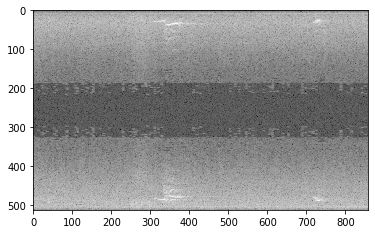

In [19]:
N = 5
plt.imshow(np.flipud(spec.detach().cpu().numpy()[N, :,:]), cmap='gray')
ipd.Audio(X.detach().cpu().numpy()[N].reshape(-1), rate=sr)


In [20]:
spec[N].max(), spec[N].min()

(tensor(0.5564, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.5760, device='cuda:0', grad_fn=<MinBackward1>))

In [21]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    
    return correct_pred.sum(), len(correct_pred)

def validate(dgen_val):
    model.eval()  
    with torch.no_grad():
        running_loss = 0.0
        total_ok = 0
        total_predictions = 0
        batches_per_epoch = len(dgen_val)
        for i, (X, y) in enumerate(dgen_val):
#             inputs, labels = torch.from_numpy(X).float().to(device), torch.from_numpy(y).long().to(device)
            inputs, labels = X.to(device), y.to(device)
            _, y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            ok, total = multi_acc(y_pred, labels)
            total_ok = total_ok + ok
            running_loss = running_loss + loss
            total_predictions = total_predictions + total
            print(f'\r{i+1}/{batches_per_epoch} - val loss: {running_loss/(i+1)}, val acc: {total_ok/total_predictions}', end='')
    model.train()
    return (running_loss/(i+1)).detach().item(), (total_ok/total_predictions).detach().item()

In [22]:
def train_model(dataset, validation_generator, epochs=1, best_val_acc = 0):
    model.train()
    batches_per_epoch = len(dataset)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        total_ok = 0
        total_predictions = 0
        for i, (X, y) in enumerate(dataset):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = X.to(device), y.to(device)
            # (1) Initialise gradients
            optimizer.zero_grad()
            # (2) Forward pass
            _, y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            running_loss = running_loss + loss
            # (3) Backward
            loss.backward()
            # (4) Compute the loss and update the weights
            optimizer.step()
            ok, total = multi_acc(y_pred, labels)
            total_ok = total_ok + ok
            total_predictions = total_predictions + total
            
            print(f'\r{epoch+1}/{epochs} - {i+1}/{batches_per_epoch} - loss: {running_loss/(i+1)}, acc: {total_ok/total_predictions}', end='')
        
        print()
        loss, acc = validate(validation_generator)
        if acc>best_val_acc:
            best_val_acc = acc
            print()
            print('Best model saved')
            torch.save(model.state_dict(), f'model_{epoch+1}_.pth')
        else:
            print()
        print('--------------------------------------------------------------------------')
        

In [23]:
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 1}
classes = np.unique(train_labels)

N = 7
training_set = Dataset(list(train_files)*N, classes, chunk_seconds=duration, sr=sr, min_std=min_std)
validation_set = Dataset(list(val_files)*N, classes, chunk_seconds=duration, sr=sr, min_std=min_std)
training_generator = torch.utils.data.DataLoader(training_set, **params)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [24]:
LEARNING_RATE = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train_model(training_generator, validation_generator, 20, best_val_acc=0.5)

1/20 - 346/346 - loss: 1.294758677482605, acc: 0.569436907768249595
78/78 - val loss: 1.7061461210250854, val acc: 0.46489101648330696
--------------------------------------------------------------------------
2/20 - 346/346 - loss: 0.7306939959526062, acc: 0.7711388468742371
78/78 - val loss: 1.2071495056152344, val acc: 0.6666666269302368
Best model saved
--------------------------------------------------------------------------
3/20 - 209/346 - loss: 0.5619911551475525, acc: 0.8187798857688904

In [66]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
X_img = torch.from_numpy(np.random.rand(2, 1, 44100)).float()